# Simulation Analysis

This jupyter notebook relies on the `AnalysisUtilities/measurements_dico.py` and allows one to retrieve easily and rapidly the simulations results and display graphs. We describe how it works here.

The first thing you should do is call the program on the data you want to analyze. In order to do so, use md.get_measurements_along(measurements,folder,convergenceFor,errors=True)


* *measurements* is a dict() of the measurements you want to be able to graph (they are loaded in memory at this point). 
  * measurements["Matsubara"] is a dict() and contains the observables with Matsubara frequency dependance. An observable should be declared as such : the key should be the observable name. The value should be an array of the wanted components (in case of multi component observables).
     * If this array contains elements, it will look for a json file which name is of the format *observable_name*i.json. The structure should be similar to selfi.json files.  (example, "green":["pphi","mphi"])
     * If the array is empty, it will look for dat files of the format *observable_name*i.dat. It will then load everythin but the first column in memory and make it available for use (example, "ChiFull":[])
  
  
  * measurements["Normal"] contains the observables with no Matsubara frequency dependance. These observables can be any name for which there exists a name.dat file in the DATA directory. But other names can be accepted (for example order or occupation, see `AnalysisUtilities/measurements_dico.py`). Those special observables computed from other observables and parameters by this program are only computed once and saved in an "*observable_name*.dat" file in the DATA directory of the simulation.
  
* *folder* is the folder in which the simulations are.
  
  
* *convergenceFor* is the number of iterations you want to mean on in order to get the result (due to error in Monte Carlo simulations). The value of the observable will be the mean on the *convergenceFor* last iterations of the simulation. This value should be chosen and then never changed. I usually use convergenceFor=15
  
  
* *errors* allows one to compute approximate errors on the graph points (the error is just $\sqrt{\frac{Var(X)}{len(convergedFor)}}$, where X is the last convergedFor iterations of the observable).
  
  

In [1]:
import json
import sys
import numpy as np
from AnalysisUtilities import utils
from AnalysisUtilities import measurements_dico as md
import matplotlib.pyplot as plt
from importlib import reload  
reload(md)
%matplotlib notebook

plt.style.use('seaborn-dark')
measurements = {"Normal" : ["N","pn","occupation","sign","order","stiffness","SzSites","Chi0"],
                   "Matsubara": []
               }

eps = [8.5,8.75,9,9.1,9.2,9.5,8]
Us = [11.75,12,12.25,12.5,12.75,13]
tpds = [1.3,1.4,1.5,1.6,1.7]
tppps = [0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3]


dico = md.get_measurements_along(measurements,"./AllData/Only_Supra/",15,errors=True)

Total number of measurement folders : 1017


Once you executed the first cell (it takes some time on new data), you can get the plottable data using just one function : 

dico.plot_dico(to_plot,orderBy = None, conds = {}).
* to_plot is an array of strings that are the different observables or parameters names you want to get. This array should not be empty.
* orderBy is used in order to order the returned arrays in function of another measurement or a parameter. It is optional and when not given, the data is orderd as a function of the first string on to_plot
* conds is a dict() of the conditions you want to impose on the returned arrays. It contains only parameter conditiions. It is optional but used almost every time.

Internally the function selects all the simulations that meet the conditions imposed by the *conds* variable. It then returns a an array of the same length as to_plot. Each element of this array is itself an array that contains the observables or parameters corresponding to all the selected simulations. If errors was set to True when defining the Measurements_dico, the last dimension of the array is of size 2, the first value being the value and the second being the error on this value (0 when you need a parameter).

We provide an example of a cell but not the data as it is relatively large (30 Mo per simulation). 
This example allows one to plot the superfluid stiffness as a function of total occupation for a certain set of parameters.

<IPython.core.display.Javascript object>


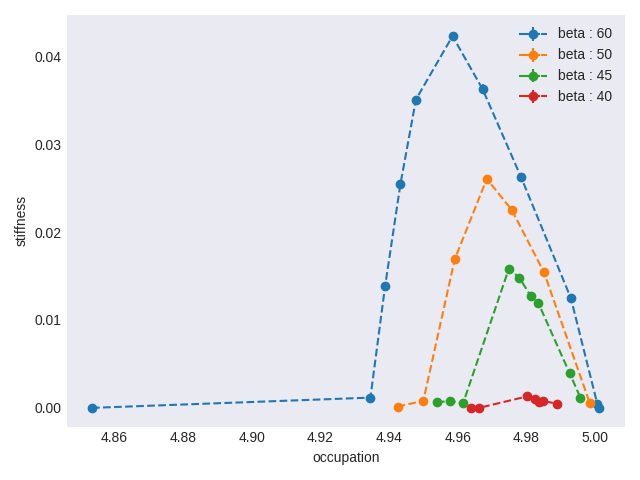

In [2]:
%matplotlib notebook
fig,ax = plt.subplots()


to_plot = ["occupation","stiffness"]

def aff(X,f,ax,label="",color = None):
    ax.set_xlabel(to_plot[0])
    ax.set_ylabel(to_plot[1])
    color = ax.errorbar(X[:,0],f[:,0],xerr=X[:,1],yerr=f[:,1], fmt='--o',label=label,color=color)[0].get_color()
    plt.tight_layout()
    return color

betas = [60,50,45,40]
for beta in betas:
    params = {"beta":beta,"ep":9,"U":12,"tpd":1.5,"tppp":0.7,"zero_order":0}
    plot_data = dico.plot_dico(to_plot,conds = params)
    mu,occupation = plot_data
    aff(mu,occupation,ax,label="beta : " + str(beta))

plt.legend()
plt.tight_layout()
plt.show()

## Example of a 3D plot

<IPython.core.display.Javascript object>


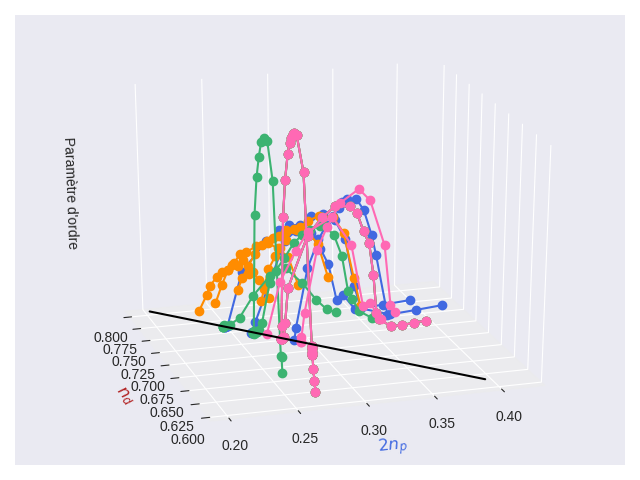

In [5]:
%matplotlib notebook
def aff_3D(X,Y,f,ax,label="",color=None):
    color = ax.plot(4 - 4*X[:,0],2 - 2*Y[:,0], f[:,0],"-o",color=color)[0].get_color()
    return color

def plot_half_3D(ax,color):
    lineHalf_y = np.linspace(ax.get_ylim()[0],ax.get_ylim()[1],2)
    lineHalf_x = 1 - lineHalf_y
    color = ax.plot(lineHalf_x,lineHalf_y,[0]*len(lineHalf_x),"-",color =color)[0].get_color()
    return color

plot_dico = {}
def add_max_3D(X,Y,f,ax,label=""):
    if label not in plot_dico:
        plot_dico[label] = {}
        plot_dico[label]["X"] = []
        plot_dico[label]["Y"] = []
        plot_dico[label]["f"] = []
    plot_dico[label]["X"].append(get_max_X(X,f))
    plot_dico[label]["Y"].append(get_max_Y(X,f))
    plot_dico[label]["f"].append(get_max_f(X,f))
    plt.tight_layout()

def get_max_X(X,f):
    return X[np.argmax(f[:,0]),0]
def get_max_Y(X,f):
    return Y[np.argmax(f[:,0]),0]
def get_max_f(X,f):
    return np.max(f[:,0])
 
def aff_max_3D(plot_dico,ax):
    for key, value in plot_dico.items():
        ax.plot(value["X"],value["Y"],[0]*len(value["X"]),"-",label=key)
    
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')



eps = [8.5,8.75,9,9.1]
Us = [12,12.25,12.5,12.75,13]
tpds = [1.3,1.4,1.5]
tppps = [0.8,1,1.2]

to_plot = ["pn","N","order"]
orderBy = "occupation"
color = "royalblue"
for ep in eps:
    params = {"beta":60,"ep":ep,"U":12,"tpd":1.5,"tppp":1.,"zero_order":0}
    X,Y,f = dico.plot_dico(to_plot,conds = params,orderBy = orderBy)
    color = aff_3D(X,Y,f,ax,label="ep",color=color)
    
color = "darkorange"
for U in Us:
    params = {"beta":60,"ep":9.0,"U":U,"tpd":1.5,"tppp":1.,"zero_order":0}
    X,Y,f = dico.plot_dico(to_plot,conds = params,orderBy = orderBy)
    color = aff_3D(X,Y,f,ax,label="U",color=color)
    
color = "mediumseagreen"
for tpd in tpds:
    params = {"beta":60,"ep":9,"U":12,"tpd":tpd,"tppp":1.,"zero_order":0}
    X,Y,f = dico.plot_dico(to_plot,conds = params,orderBy = orderBy)
    color = aff_3D(X,Y,f,ax,label="tpd",color=color)
    
color = "hotpink"
for tppp in tppps:
    params = {"beta":60,"ep":9,"U":12,"tpd":1.5,"tppp":tppp,"zero_order":0}
    X,Y,f = dico.plot_dico(to_plot,conds = params,orderBy = orderBy)
    color = aff_3D(X,Y,f,ax,label="tppp",color=color)

    
#We plot the half-filling line
color = "black"
plot_half_3D(ax,color)



ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.set_zticks([])
ax.view_init(elev=24., azim=-107)

ax.set_ylabel("$n_d$", fontsize=12, fontweight='bold',color="firebrick")
ax.set_xlabel("$2n_p$", fontsize=12, fontweight='bold',color="royalblue")
ax.set_zlabel("Paramètre d'ordre")

plt.tight_layout()
plt.show()